# Inference Speedup

## Seminar

Some functions, classes and variables required for the homework part are defined in the seminar's code.

In [1]:
import time
from typing import List
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import triton
import triton.language as tl

print("torch version:", torch.__version__)
print("triton version:", triton.__version__)

from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

torch version: 2.5.1+cu124
triton version: 3.1.0


### Catch activation and weight

In [2]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# challenging input
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

In [4]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generation_output = model.generate(**model_inputs, streamer=streamer, max_new_tokens=1024)

To achieve the described functionality, we will break down the task into several steps:

1. Parse the input JSON and extract relevant data.
2. Prepare the data for insertion into the Google Sheet.
3. Connect to the Google Sheet using the Google Sheets API.
4. Insert the data into the appropriate columns.

### Step 1: Parse the Input JSON

We will parse the provided JSON to extract the necessary fields.

```python
import json

def parse_json(json_data):
    parsed_data = {
        'date': json_data['date'],
        'revenue': json_data['revenue'],
        'person': json_data['person'],
        'expenses': [
            {'amount': expense, 'description': description, 'type': type} 
            for expense, description, type in zip(
                json_data['expensesList'], 
                json_data['expensesDescList'], 
                json_data['expensesTypeList']
            )
        ]
    }
    return parsed_data
```

### Step 2: Prepare Data for Insertion

We will prepare the data

In [5]:
class Catcher(nn.Module):
    def __init__(self, inps: List, module: nn.Module):
        super().__init__()
        self.backup = module
        self.inps = inps

    def forward(self, inp, **kwargs):
        self.inps.append(inp.to("cpu"))
        raise ValueError

In [6]:
layer = model.model.layers[0]
inps = []
layer.self_attn.q_proj = Catcher(inps, layer.self_attn.q_proj) # wrap

In [7]:
try:
    model(model_inputs.input_ids)
except ValueError as e:
    layer.self_attn.q_proj = layer.self_attn.q_proj.backup

In [8]:
inps[0].shape

torch.Size([1, 700, 2048])

In [9]:
weight = layer.self_attn.q_proj.weight # unwrap

### Triton GeMM

#### When to Use Triton
- Optimization Steps:
1. Use torch.compile():
    - Start by using torch.compile() to optimize your code.
2. Adapt Your Code:
    - Rewrite code to be more suitable for torch.compile().
        - E.g., eliminate graph breaks to enable CUDA graphs.
3. Profile and Identify Bottlenecks:
    - Find slow parts of your code using profiling tools.
    - Write custom Triton kernels for these parts.
4. Consider CUDA:
    - If still not fast enough, write custom CUDA kernels.

**Note**: For maximum performance from the start, you may choose CUDA directly.

#### Rough Edges in Triton
- New-ish Project:
    - Contains rough edges; code may not behave as expected.
    - Expected to become more polished over time.
- Recommendation:
    - Debugging is important; use “simulator mode” when possible.
    - Be aware of limitations on older GPUs or with certain operations.

Resources (most useful):
- [GPU MODE Lecture 14: Practitioners Guide to Triton](https://christianjmills.com/posts/cuda-mode-notes/lecture-014/#auto-tuning) – basic description about development on Triton, its pros and cons, practical examples with elaborated comments and something about optimization.
- [Flash-Decoding for long-context inference](https://pytorch.org/blog/flash-decoding/) – description of SPLIT_K optimization for fasted inference at autoregressive decoding stage due to better GPU utilization.

Less useful, but interesting:
- [Deep Dive on the Hopper TMA Unit for FP8 GEMMs](https://pytorch.org/blog/hopper-tma-unit/) – importance of TMA unit for Hopper and BlackWell.
- [Persistent Matmul](https://triton-lang.org/main/getting-started/tutorials/09-persistent-matmul.html) – special version of GeMM for Hopper and BlackWell with TMA support.


In [10]:
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

assert is_cuda(), "CUDA only tutorial"
ref_lib = 'cuBLAS'

In [11]:
def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        # custom
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")

In [12]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, allow_tf32=False)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(c_ptr.dtype.element_ty)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)

In [13]:
def matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

Sanity check on quality:

In [14]:
torch.manual_seed(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)

if torch.allclose(triton_output, torch_output, atol=2e-2):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")
    print(f"triton_output_with_fp16_inputs={triton_output}")
    print(f"torch_output_with_fp16_inputs={torch_output}")
    assert False, "Check quality"

✅ Triton and Torch match


In [15]:
seqlen = inps[0].shape[1]
hidden_size = inps[0].shape[2]
seqlen, hidden_size


def prepare_a(M: int):
    inp = inps[0][0]
    if M > seqlen:
        n_repeats = M // seqlen + 1
        return inp.repeat(n_repeats, 1)[:M]
    else:
        return inp[:M]


def benchmark(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    a = prepare_a(M).to(torch.float16).cuda()
    b = weight.T.to(torch.float16)
    assert a.shape == (M, K), f"{a.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](a, b), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


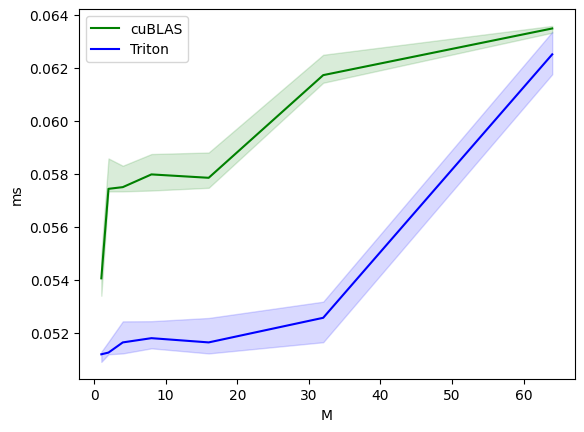

GeMV-performance-fp16:
      M    cuBLAS    Triton
0   1.0  0.054064  0.051200
1   2.0  0.057440  0.051264
2   4.0  0.057504  0.051648
3   8.0  0.057984  0.051808
4  16.0  0.057856  0.051648
5  32.0  0.061728  0.052576
6  64.0  0.063488  0.062512


KeyboardInterrupt: 

In [17]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMV-performance-" + ("fp16"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": {"triton": matmul, "cublas": torch.matmul}},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMM-performance-" + ("fp16"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": {"triton": matmul, "cublas": torch.matmul}},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)

## HW    (10 points total, 4 bonus points)

### Dynamic W8A8 GeMM (6 points)

> **Important disclaimer:** please do the assignment in Google Colab on Nvidia Tesla T4 GPU -- it has all the required dependecies pre-installed and will save you lots of time.

For the disobedient: on other GPU types (H100) the code will need to be significantly rewritten to account for architectural features for maximum performance (see "less useful but interesting" above in the seminar).

> **Important disclaimer 2:** to complete the homework, you need to run the seminar code above, it contains the necessary helper functions.

Useful resources:
- [Matrix Multiplication Background User's Guide](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html)
- [Deep Dive on CUTLASS Ping-Pong GEMM Kernel](https://pytorch.org/blog/cutlass-ping-pong-gemm-kernel/)
- [Accelerating 2D Dynamic Block Quantized Float8 GEMMs in Triton](https://pytorch.org/blog/accelerating-gemms-triton/)

![](https://habrastorage.org/webt/xq/r5/8a/xqr58aw0gd6tdm-j45yqad67w1a.png)

#### Quantization kernel (2 points)

In this task you will need to implement fast quantization operation in per-row mode:
1. You need to fill in the gaps marked with `YOUR CODE HERE`, please do not delete these comments with the task and marking as it makes checking easier
2. Next to each gap there is a comment with `# !!! TASK: ...` that will help understand what exactly needs to be written
3. The illustration above shows exactly which dimensions are used to calculate scales for activation and weight matrices
4. The formula is `scales = tensor.abs().max(axis=axis) / INT8_max_value`

In [16]:
@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
     ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
    fpa_ptr, a_ptr, as_ptr,
    M, K,
    stride_fpam, stride_fpak,
    stride_am, stride_ak,
    stride_asm,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid_m = tl.program_id(axis=0)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak
    a_max = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)

        # !!! TASK: calc maximum absolute value of each row of fpa and update a_max
        # YOUR CODE HERE
        a_max = tl.maximum(a_max, tl.max(fpa.abs(), axis=-1))
        # YOUR CODE HERE

        fpa_ptrs += BLOCK_SIZE_K * stride_fpak

    # !!! TASK: divide a_max by max positive INT8 value
    # YOUR CODE HERE
    a_scale = a_max / 127
    # YOUR CODE HERE

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)

        # !!! TASK: divide fpa by a_scale and convert to INT8
        # YOUR CODE HERE
        inta = (fpa / a_scale).to(tl.int8)
        # YOUR CODE HERE

        tl.store(a_ptrs, inta, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K)
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
        a_ptrs += BLOCK_SIZE_K * stride_ak
    as_offs = pid_m * BLOCK_SIZE_M * stride_asm + tl.arange(0, BLOCK_SIZE_M)
    tl.store(as_ptr + as_offs, a_scale)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale


def quantize_int8(weight, axis=0, tp_rank=0):
    # Weight shape: [H1, H2]
    # Scale shape: [H2]

    # !!! TASK: calculate scale by taking maximum over axis and saving dims and divide on maximum positive INT8 value
    # YOUR CODE HERE
    scale = torch.max(weight.abs(), dim=0, keepdim=True)[0] / 127
    # YOUR CODE HERE

    # !!! TASK: divide weight by scale and convert to int8
    # YOUR CODE HERE
    weight = (weight / scale).to(torch.int8)
    # YOUR CODE HERE

    # col major will accelerate i8xi8 kernel.
    if axis == 0:
        weight = weight.t().contiguous().t()
    scale = scale.squeeze(axis)
    return weight.contiguous().cuda(tp_rank), scale.contiguous().cuda(tp_rank)


#### Per-row W8A8 GeMM (4 points)

Next we need to implement a fast operation for per-row W8A8 GeMM:
1. To do this, you need to fill in the gaps marked with `YOUR CODE HERE`. Please do not delete these comments with the task and marking as it makes checking easier
2. Next to each gap there is a comment with `# !!! TASK: ...` that will help understand what exactly needs to be written

In [38]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def perrow_w8a8_matmul_kernel(
    # Pointers to matrices
    a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_asm,
    stride_bk, stride_bn,
    stride_bsn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    as_ptrs = as_ptr + offs_am * stride_asm
    bs_ptrs = bs_ptr + offs_bn * stride_bsn
    a_scale = tl.load(as_ptrs, mask=offs_am < M, other=0.0)
    b_scale = tl.load(bs_ptrs, mask=offs_bn < N, other=0.0)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.

    # !!! TASK: create accumulator of int32 dtype
    # YOUR CODE HERE
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)
    # YOUR CODE HERE

    # !!! TASK: implement the loop over K dimension.
    # In the loop first load next blocks of A and B, using an appropriate mask over K dimension.
    # Then, multiply blocks and update the accumulator
    # Finally, update the pointers to A and B matrix.
    # You can rely on implementation of regular matmul from the seminar

    # YOUR CODE HERE
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, out_dtype=tl.int32)
        # tl.dot(a, b, acc=accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # YOUR CODE HERE

    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!

    # !!! TASK: dequantize the accumulator with a_scale and b_scale (outer product) and convert to c_ptr.dtype.element_ty
    # YOUR CODE HERE
    c = (a_scale[:, None] * accumulator.to(tl.float32) * b_scale).to(c_ptr.dtype.element_ty)
    # c = (accumulator).to(c_ptr.dtype.element_ty)

    # YOUR CODE HERE

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out == None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    perrow_w8a8_matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )
    return c


def matmul_quantize_int8(fpa, b, b_scale, out=None):
    # !!! TASK: quantize fpa to int8 and call matmul_int8
    # YOUR CODE HERE
    a, a_scale = quantize_int8_perrow(fpa)
    return matmul_int8(a, a_scale, b, b_scale, out=out)
    # YOUR CODE HERE


In [109]:
a.shape, b.shape

(torch.Size([700, 2048]), torch.Size([2048, 2048]))

Sanity check (heavily relaxed for non-smoothed case):

In [39]:
torch.manual_seed(42)
cos = torch.nn.CosineSimilarity(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

int_a, scale_a = quantize_int8_perrow(a)
int_b, scale_b = quantize_int8(b, axis=0)


triton_output = matmul_int8(int_a, scale_a, int_b, scale_b)
torch_output = torch.matmul(a, b)

if (torch_output.float() - triton_output.float()).abs().mean() < 0.03 and torch.quantile((torch_output.float() - triton_output.float()).abs(), 0.95) < 0.07:
    print("✅ Triton FP8 and Torch match")
else:
    print("❌ Triton FP8 and Torch differ")
    print("Quantization cos: ", cos((int_a * scale_a.unsqueeze(1)).flatten().to(torch.float32), a.flatten().to(torch.float32)).item())

    print('=' * 50)
    print(f"triton_output_with_fp8={triton_output}")
    print(f"torch_output={torch_output}")

    print('=' * 50)
    print("infs in triton:", (triton_output).isinf().sum())
    print("infs in torch:", (torch_output).isinf().sum())

    print('=' * 50)
    print("Output cos:", cos(triton_output.flatten().to(torch.float32), torch_output.flatten().to(torch.float32)).item())
    print(((triton_output - torch_output).abs() >= 0.5).sum())
    print(((triton_output - torch_output).abs() / (torch_output.abs() + 1e-5)))
    assert False, "Triton and Torch differ"

✅ Triton FP8 and Torch match


Sanity checks on perf:

In [40]:
def test_perf_quantize(M: int, K: int, iters: int = 256, thr: float = 1.3):
    torch.manual_seed(0)
    print(f"M: {M} K: {K}")

    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    # warmup
    for _ in range(10):
        int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()

    t1 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    t2 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8(a, axis=1)
    torch.cuda.synchronize()
    t3 = time.time()

    torch_time = (t3 - t2) / iters
    triton_time = (t2 - t1) / iters

    print(f"Torch time cost: {torch_time}")
    print(f"Triton time cost: {triton_time}")
    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time


def test_perf_matmul_int8(M, K, N, iters: int = 512, thr: float = 0.99):
    print("M: {} K: {} N: {}".format(M, K, N))
    torch.manual_seed(0)
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous()
    int_b, scale_b = quantize_int8(b, axis=0)
    for _ in range(10):
        # int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t1 = time.time()
    for _ in range(iters):
        #int_a, a_scale, _ = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    qt2 = time.time()
    for _ in range(iters):
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t2 = time.time()
    quant_time = qt2 - t1
    triton_time = t2 - qt2
    triton_tflops = 2 * M * N * K * 1e-12 / (triton_time / iters)
    quant_bandwith = 2 * M * K * 1e-9 / (quant_time / iters)
    print("Triton time cost: {} (tflops {}) + quant: {} (bandwidth {})".format(
        triton_time, triton_tflops, quant_time, quant_bandwith))
    for _ in range(10):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    t2 = time.time()
    torch_time = t2 - t1
    torch_tflops = 2 * M * N * K * 1e-12 / (torch_time / iters)
    print("Torch time cost: {} (tflops {})".format(t2 - t1, torch_tflops))

    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time, quant_time


def test_perf_model_layer(bs, seq_len, hidden, inter, tp, thr: float = 0.99):
    st1 = 0
    st2 = 0
    st3 = 0
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, hidden * 3 // tp, thr=thr)
    test_perf_quantize(bs * seq_len, hidden, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, hidden // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, inter * 2 // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, inter // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, inter // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    print("Triton time {} Torch time {} Quant time {}".format(st1, st2, st3))
    assert st2 / st1 > thr, f"Must get at least {thr}x speedup"

In [41]:
bs = 32
hidden = model.config.hidden_size
inter  = model.config.intermediate_size
prefill_len = 512
decode_len = 1
tp = 1

In [42]:
test_perf_model_layer(bs, prefill_len, hidden, inter, tp, thr=1.3)

M: 16384 K: 2048 N: 6144
Triton time cost: 7.741472482681274 (tflops 27.269519203906665) + quant: 0.2225949764251709 (bandwidth 154.35990029878602)
Torch time cost: 10.65448546409607 (tflops 19.813836458305435)
M: 16384 K: 2048
Torch time cost: 0.002474013715982437
Triton time cost: 0.0004185568541288376
M: 16384 K: 2048 N: 2048
Triton time cost: 2.383049726486206 (tflops 29.528861020211412) + quant: 0.22102046012878418 (bandwidth 155.459536859073)
Torch time cost: 3.2085819244384766 (tflops 21.931415757750678)
M: 16384 K: 2048
Torch time cost: 0.002456286922097206
Triton time cost: 0.0004271911457180977
M: 16384 K: 2048 N: 22016
Triton time cost: 25.069923877716064 (tflops 30.174164213649135) + quant: 0.22312092781066895 (bandwidth 153.99603571546743)
Torch time cost: 42.283515214920044 (tflops 17.890281734262345)
M: 16384 K: 11008 N: 2048
Triton time cost: 12.06530499458313 (tflops 31.348730937573148) + quant: 1.527789831161499 (bandwidth 120.8828531000201)
Torch time cost: 20.813440

Note: The last line should show the overall speedup per layer at the prefill stage. For Nvidia Tesla T4 and fixed library versions, our implementation is about 1.6x faster.

In [43]:
test_perf_model_layer(bs, decode_len, hidden, inter, tp, thr=0.1)

M: 32 K: 2048 N: 6144
Triton time cost: 0.04182744026184082 (tflops 9.857568568262513) + quant: 0.028662919998168945 (bandwidth 2.34131288802003)
Torch time cost: 0.0617215633392334 (tflops 6.680272470576101)
M: 32 K: 2048
Torch time cost: 6.809551268815994e-05
Triton time cost: 5.3233467042446136e-05
M: 32 K: 2048 N: 2048
Triton time cost: 0.07812714576721191 (tflops 1.7591702873865875) + quant: 0.05276036262512207 (bandwidth 1.2719560795445677)
Torch time cost: 0.021044492721557617 (tflops 6.530875098320136)
M: 32 K: 2048
Torch time cost: 9.969808161258698e-05
Triton time cost: 8.71485099196434e-05
M: 32 K: 2048 N: 22016
Triton time cost: 0.15679526329040527 (tflops 9.422916986258285) + quant: 0.028576135635375977 (bandwidth 2.3484233437400905)
Torch time cost: 0.21704483032226562 (tflops 6.807205440600781)
M: 32 K: 11008 N: 2048
Triton time cost: 0.10643649101257324 (tflops 6.940611888687067) + quant: 0.027135133743286133 (bandwidth 13.293103598181016)
Torch time cost: 0.10500216484

Note: The last line shows the per-layer comparison at the decode stage. For the same Nvidia Tesla T4 and libraries, the speedup turned out to be much lower (x1.03). To speed up decode, a CUDA implementation is needed.

Benchmarks:

In [44]:
@torch.no_grad()
def benchmark_quant_gemm(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    fpa = prepare_a(M).to(torch.float16).cuda().contiguous()
    fpb = weight.data.T.to(torch.float16).contiguous()
    b, b_scale = quantize_int8(fpb, axis=0)

    assert fpa.shape == (M, K), f"{fpa.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](fpa, fpb, b, b_scale), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

In [45]:
provider_funcs = {
    "triton int8": lambda fpa, fpb, b, b_scale: matmul_quantize_int8(fpa, b, b_scale),
    "triton fp16": lambda fpa, fpb, b, b_scale: matmul(fpa, fpb),
    "cublas fp16": lambda fpa, fpb, b, b_scale: torch.matmul(fpa, fpb)
}

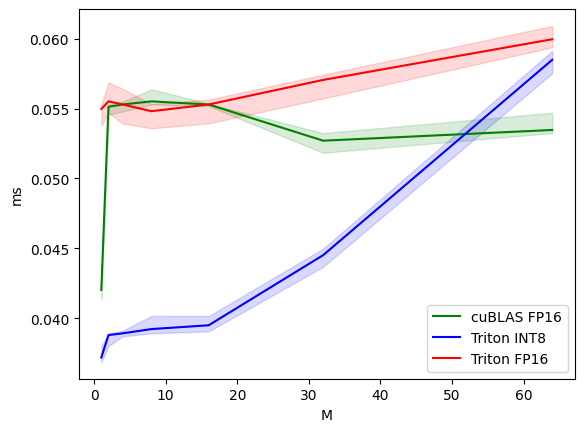

GeMV-performance-FP16 vs INT8:
      M  cuBLAS FP16  Triton INT8  Triton FP16
0   1.0     0.042016     0.037184     0.054976
1   2.0     0.055136     0.038784     0.055520
2   4.0     0.055296     0.038912     0.055296
3   8.0     0.055520     0.039216     0.054816
4  16.0     0.055296     0.039488     0.055296
5  32.0     0.052704     0.044512     0.057056
6  64.0     0.053472     0.058496     0.059968


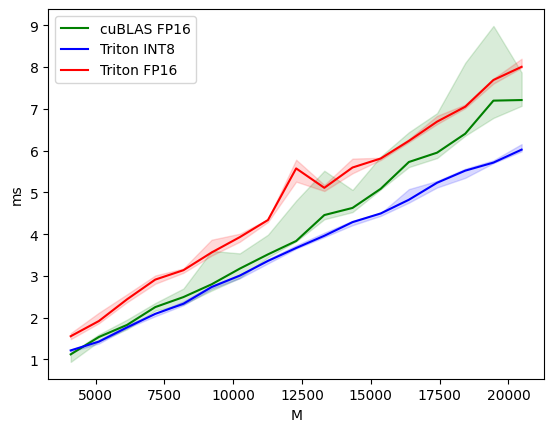

GeMM-performance-FP16 vs INT8:
          M  cuBLAS FP16  Triton INT8  Triton FP16
0    4096.0     1.123264     1.217232     1.556736
1    5120.0     1.538272     1.427904     1.920560
2    6144.0     1.827712     1.767776     2.440480
3    7168.0     2.253952     2.091888     2.911904
4    8192.0     2.493616     2.333968     3.137216
5    9216.0     2.799168     2.734080     3.560592
6   10240.0     3.174400     3.007584     3.928064
7   11264.0     3.515872     3.359296     4.337664
8   12288.0     3.835776     3.668560     5.572640
9   13312.0     4.456448     3.960832     5.108544
10  14336.0     4.627120     4.286848     5.594128
11  15360.0     5.084736     4.495168     5.809696
12  16384.0     5.726224     4.822416     6.231024
13  17408.0     5.949472     5.229472     6.691776
14  18432.0     6.403328     5.519360     7.049152
15  19456.0     7.194656     5.711824     7.688512
16  20480.0     7.208880     6.021872     8.003584


In [46]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["cublas fp16", "triton int8", "triton fp16"],  # Label name for the lines
        line_names=["cuBLAS FP16", "Triton INT8", "Triton FP16"],  # Line styles
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMV-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["cublas fp16", "triton int8", "triton fp16"],  # Label name for the lines
        line_names=["cuBLAS FP16", "Triton INT8", "Triton FP16"],  # Line styles
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMM-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark_quant_gemm).run(show_plots=True, print_data=True)

**Note:** We significantly outperformed Triton FP16 in terms of speed, and even managed to accelerate on prefill with large contexts compared to cuBLAS.

In [47]:
provider_funcs = {
    "torch": lambda a, b: quantize_int8(a),
    "triton": lambda a, b: quantize_int8_perrow(a)
}

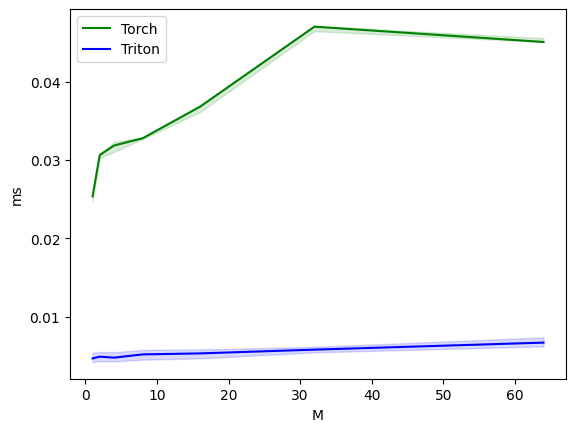

Quantize-performance-decoding:
      M     Torch    Triton
0   1.0  0.025344  0.004672
1   2.0  0.030624  0.004896
2   4.0  0.031840  0.004768
3   8.0  0.032768  0.005184
4  16.0  0.036784  0.005312
5  32.0  0.047008  0.005792
6  64.0  0.045056  0.006688


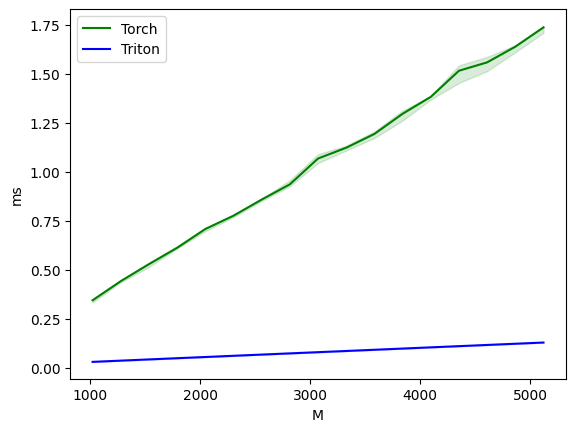

Quantize-performance-prefill:
         M     Torch    Triton
0   1024.0  0.344448  0.030432
1   1280.0  0.441888  0.036736
2   1536.0  0.528448  0.042944
3   1792.0  0.611888  0.049152
4   2048.0  0.707584  0.055232
5   2304.0  0.775584  0.061440
6   2560.0  0.857792  0.067584
7   2816.0  0.935520  0.073728
8   3072.0  1.067008  0.079872
9   3328.0  1.122128  0.085968
10  3584.0  1.192272  0.092144
11  3840.0  1.295040  0.098240
12  4096.0  1.381312  0.104448
13  4352.0  1.514512  0.110592
14  4608.0  1.557328  0.116704
15  4864.0  1.637088  0.122880
16  5120.0  1.735552  0.129024


In [48]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("decoding"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("prefill"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)

**Note:** The PyTorch implementation for quantization is extremely inefficient and Triton quantization performs significantly better on both prefill and decode

### Bonus task: SmoothQuant (4 points)

Your task is to use your implementation of dynamic w8a8 GeMM for real-world LLM inference speedup. Read the paper below and implement the algorithm:
1. Smooth your model. You may want to write custom triton kernel for fast activation smoothing in runtime (or leave it in torch).
2. After that validate the model quality (e.g. perplexity).
3. Create `W8A8Linear` module, which smooths and dynamically quantizes activations and performs quantized GeMM with already smoothed and quantized INT8 weights.
4. Replace all linear layers with `W8A8Linear` (quantize your smoothed weight).
5. Validate quantized model. Your should experience no drop in quality.
6. Measure end-to-end speedup.
7. 🤝🏻 Get my personal respect

Resources:
- https://arxiv.org/abs/2211.10438
- [SmoothQuant repo](https://github.com/mit-han-lab/smoothquant)

### Vanilla SpecDec (4 points)

_Special thanks to @hawkeoni for this part of HW._

In [1]:
# You might want to reload the notebook. In such case, run this cell.
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device cuda


#### Init

In [2]:
if True:
    name_big = "unsloth/Llama-3.2-3B-Instruct"
    name_small = "unsloth/Llama-3.2-1B-Instruct"
else:
    name_big = "openai-community/gpt2-medium"
    name_small = "openai-community/gpt2"

model_3b = AutoModelForCausalLM.from_pretrained(name_big).to(device)
model_1b = AutoModelForCausalLM.from_pretrained(name_small).to(device)


tokenizer = AutoTokenizer.from_pretrained(name_big)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-03-26 11:17:51.417564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 11:17:55.861799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.

In [33]:
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

#### Greedy SpecDec (3 points)

In this task, you need to implement speculative decoding in PyTorch. **Generation must be done greedily.**

1. Generate n tokens using the small model
2. Check if the big model would choose these same tokens during greedy generation (only one forward pass of the big model should be called, using big_model.generate is not allowed at this stage)
3. If all tokens are chosen by the big model, accept them and return to step 1
4. If any token is chosen incorrectly, use the correct token from step 2 instead and return to step 1.

In [58]:
@torch.no_grad()
def speculative_generate(big_model, small_model, prefix: str, max_num_tokens: int, n: int) -> tuple[str, int, int]:
    """Vanilla speculative decoding for greedy generation.

    Args:
        big_model: original big HF model (verifier).
        small_model: small HF model (draft).
        prefix (str): prompt.
        max_num_tokens (int): max tokens to generate.
        n (int): number of tokens to speculate.

    Returns: generated text, number of accepted tokens, number of all tokens.
    """

    input_ids = tokenizer(prefix, return_tensors="pt").input_ids.to(device)
    start_size = input_ids.size(1)
    cnt_accepted = 0
    cnt_all = 0
    while input_ids.size(1) - start_size < max_num_tokens:
        # !!! TASK: Generate a sequence using the small model
        small_generation = small_model.generate(input_ids, max_new_tokens=n)
        num_generated_tokens = small_generation.size(1) - input_ids.size(1)
        # print(f"Generated {num_generated_tokens} new tokens")

        # !!! TASK: Check the sequence using the big model
        big_model_logits = big_model(small_generation).logits
        big_model_generations = torch.argmax(big_model_logits[:, input_ids.size(1) - 1:, :], dim=-1)
        # print(big_model_generations.shape)

        mismatch = False
        for i in range(num_generated_tokens):
            # !!! TASK: found a mismatch at position i
            if big_model_generations[0, i] != small_generation[0, input_ids.size(1) + i]:
                mismatch = True
                # !!! TASK: if the first token is incorrect, take the first token predicted by the big model
                if i == 0:
                    input_ids = torch.cat(
                        [input_ids, big_model_generations[:, 0].reshape(-1, 1)],
                        dim=1
                    )
                # !!! TASK: otherwise take previous tokens predicted by the small model + the correct token from the big model
                else:
                    input_ids = torch.cat(
                        [input_ids, 
                         small_generation[:, input_ids.size(1)].reshape(-1, 1), 
                         big_model_generations[:, 1].reshape(-1, 1)],
                        dim=1
                    )
                print(f"Accepted {i}/{n} tokens")
                cnt_accepted += i
                cnt_all += n
                break

        if not mismatch:
            # !!! TASK: if there was no mismatch, accept the entire sequence + the last token from the big model
            input_ids = torch.cat([input_ids, small_generation[:, input_ids.size(1):], big_model_generations[:, 2].reshape(-1, 1)], dim=1)
        # print(input_ids.shape)

    # !!! TASK: use tokenizer to decode generated ids
    decoded_text = tokenizer.decode(input_ids[0, start_size:start_size+max_num_tokens])
    return decoded_text, cnt_accepted, cnt_all, input_ids

In [59]:
res_spec, cnt_accepted, cnt_all, res_ids = speculative_generate(big_model=model_3b, small_model=model_1b, prefix=prompt, max_num_tokens=128, n=2)

Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 1/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens
Accepted 0/2 tokens
Accepted 0/2 tokens
Accepted 1/2 tokens


In [60]:
res_ids.shape

torch.Size([1, 773])

In [53]:
model_inputs = tokenizer([prompt], return_tensors="pt").to(device)
res_big = tokenizer.batch_decode(
    model_3b.generate(**model_inputs, do_sample=False, max_new_tokens=128)[:, model_inputs.input_ids.shape[1]:],
    skip_special_tokens=True
)[0]

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [54]:
res_big

"Instead, use the service account credentials file to authenticate.\n\n## QUESTION\n\nHow can I write a python function that receives the JSON data and enters it into the Google Sheet using service account credentials file?\n\n## ANSWER\n\n### CHAIN OF THOUGHTS\n\n1. **OBEY the EXECUTION MODE**\n2. **TASK ANALYSIS:**\n   - Understand the user's request thoroughly.\n   - Identify the key components and requirements of the task.\n   - The task is to write a python function that receives the JSON data and enters it into the Google Sheet using service account credentials file.\n3.  **PLANNING:"

In [61]:
res_spec

"Instead, use the service account credentials file to authenticate.\n\n## QUESTION\n\nHow can I write a python function that receives the JSON data and enters it into the Google Sheet using service account credentials file?\n\n## ANSWER\n\n### CHAIN OF THOUGHTS\n\n1. **OBEY the EXECUTION MODE**\n2. **TASK ANALYSIS:**\n   - Understand the user's request thoroughly.\n   - Identify the key components and requirements of the task.\n   - The task is to write a python function that receives the JSON data and enters it into the Google Sheet using service account credentials file.\n3.  **PLANNING:"

In [62]:
len(res_big), len(res_spec)

(580, 580)

In [63]:
assert res_big == res_spec and len(res_big) == len(res_spec)

In [64]:
assert cnt_accepted / cnt_all > 0.19

#### HF SpecDec (1 point)

Now try using the speculative decoding function from [transformers](https://huggingface.co/docs/transformers/main/en/generation_strategies#speculative-decoding)

In [68]:
import time

# !!! TASK: generate with assistant_model and compare with big model inference time
inputs = model_inputs
max_new_tokens = 256

# SpecDec from HF
start = time.time()
outputs = model_3b.generate(**inputs, max_new_tokens=max_new_tokens, assistant_model=model_1b)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
print(f"Elapsed time for speculative {time.time() - start}")

# ordinary
start = time.time()
outputs = model_3b.generate(**inputs, max_new_tokens=max_new_tokens)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
print(f"Elapsed time for big model inference {time.time() - start}")

['\n# SYSTEM PREAMBLE\n1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.\n2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.\n3) You have to return the entire code.\n4) Follow "Answering rules" without exception.\n\n## ANSWERING RULES\n1) Repeat the question before answering it.\n2) Always follow "CHAIN OF THOUGHTS" to execute the task.\n\n## CHAIN OF THOUGHTS\n1) **OBEY the EXECUTION MODE**\n2) **TASK ANALYSIS:**\n   - Understand the user\'s request thoroughly.\n   - Identify the key components and requirements of the task.\n3) **PLANNING: CODDING:**\n   - Break down the task into logical, sequential steps.\n   - Outline the strategy for implementing each step.\n4) **CODING

Make a conclusion about the efficiency of SpecDec implementation in HF.

**Conslusion:**
-  SpecDec implementation in HF is shit lol